# Applying WOfS Bitmasking <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls_usgs_wofs_scene](https://explorer.digitalearth.africa/ls_usgs_wofs_scene),
[ls_usgs_fc_scene](https://explorer.digitalearth.africa/ls_usgs_fc_scene)

## Background
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) product shows water observed for Landsat-8 image for selected areas of Africa.

Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. 
Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

## Description
This notebook explains both the structure of the WOFLs, and how you can use this for powerful and flexible image masking.

The data in a WOFL is stored as a bit field. 
This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc).
In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 

The notebook demonstrates how to:

1. Load WOFL data for a given location and time period
2. Inspect the WOLF bit flag information
3. Use the WOFL bit flags to create a binary mask
4. Apply WOFL-based masks to different datasets

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

### Load packages

In [1]:
%matplotlib inline

import datacube
from datacube.storage import masking
import matplotlib.pyplot as plt
import numpy as np

from deafrica_tools.plotting import display_map
from deafrica_tools.datahandling import wofs_fuser, mostcommon_crs

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Applying_WOfS_bitmasking")

### Analysis parameters
To load WOFL data, we can first create a re-usable query that will define the spatial extent and time period we are interested in, as well as other important parameters that are used to correctly load the data.

In [3]:
lat, lon =  -4.9, 39.2
buffer = 0.125

x = (lon-buffer, lon+buffer)
y =  (lat+buffer, lat-buffer)

# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': ('2001-10-01', '2001-12-01'),
    'resolution': (-30, 30)
}

output_crs = mostcommon_crs(dc=dc, product='ls_usgs_wofs_scene', query=query)

### View the selected location

In [4]:
display_map(x=x, y=y)

## Load WOFL data


As WOFLs are created scene-by-scene, and some scenes overlap, it's important when loading data to `group_by` solar day, and ensure that the data between scenes is combined correctly by using the WOfS `fuse_func`.
This will merge observations taken on the same day, and ensure that important data isn't lost when overlapping datasets are combined.

In [5]:
# Load the data from the datacube
wofls = dc.load(product="ls_usgs_wofs_scene", output_crs=output_crs, group_by="solar_day",
                            fuse_func=wofs_fuser, **query)

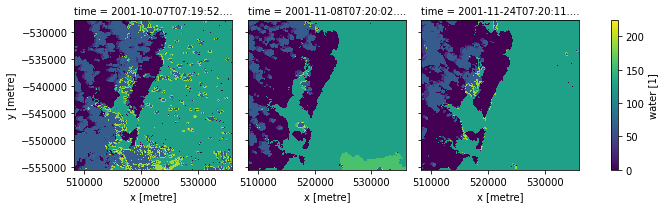

In [6]:
# Plot the loaded WOFLs
wofls.water.plot(col="time", col_wrap=3)
plt.show()

In [7]:
# Select one image of interest (`time=2` selects the third observation)
wofl = wofls.isel(time=2)

### Understanding the WOFLs

As mentioned above, WOFLs are stored as a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular feature. Below is a breakdown of which bits represent which features, along with the decimal value associated with that bit being set to true.

| Attribute | Bit / position   | Decimal value |
|------|------|----|
| No data | 0:   `0-------` or `1-------` | 1|
| Non contiguous | 1:   `-0------` or `-1------` | 2 |
| Sea | 2:   `--0-----` or `--1-----` | 4 |
| Terrain or low solar angle | 3:   `---0----` or `---1----` | 8 |
| High slope | 4:   `----0---` or `----1---` | 16 |
| Cloud shadow | 5:   `-----0--` or `-----1--` | 32 |
| Cloud | 6:   `------0-` or `------1-` | 64 |
| Water | 7:   `-------0` or `-------1` | 128 |


The values in the above plots are the decimal representation of the combination of set flags. 
For example a value of 136 indicates water (128) AND terrain shadow / low solar angle (8) were observed for the pixel,
whereas a value of 144 would indicate water (128) AND high slope (16).

This flag information is available inside the loaded data and can be visualised as below

In [8]:
# Display details of available flags
flags = masking.describe_variable_flags(wofls)
flags["bits"] = flags["bits"].astype(str)
flags.sort_values(by="bits")

,bits,values,description
nodata,0,"{'0': False, '1': True}",No data
sea,2,"{'0': False, '1': True}",Sea
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
cloud,6,"{'0': False, '1': True}",Cloudy
water_observed,7,"{'0': False, '1': True}",Classified as water by the decision tree
dry,"[7, 6, 5, 0]",{'0': True},Clear and dry
wet,"[7, 6, 5, 0]",{'128': True},Clear and Wet


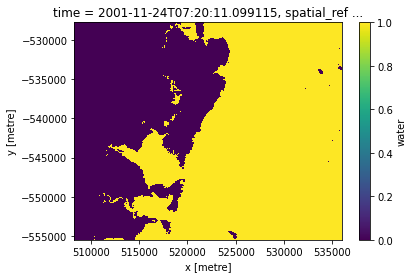

In [9]:
# Show areas flagged as water only (with no other flags set)
(wofl.water == 128).plot.imshow()
plt.show()

## Masking 
We can convert the WOFL bit field into a binary array containing True and False values. 
This allows us to use the WOFL data as a mask that can be applied to other datasets.

The `make_mask` function allows us to create a mask using the flag labels (e.g. "wet" or "dry") rather than the binary numbers we used above.


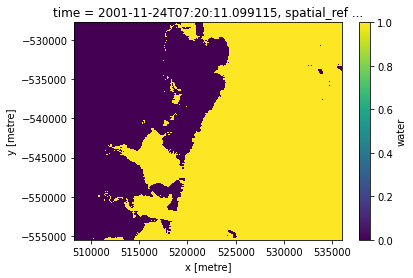

In [10]:
# Create a mask based on all 'wet' pixels
wetwofl = masking.make_mask(wofl, wet=True)
wetwofl.water.plot()
plt.show()

### Load something to mask
In the following example, we demonstrate how WOFS can be used as a mask to remove certain features (e.g. water) from another dataset.

We will apply the mask to the 'Fractional Cover' (FC) dataset.
This dataset estimates the percentage of photosythetic vegetation, non-photosythetic vegetation and bare soil within each satellite pixel, but gives inaccurate values in pixels that contain water.
We can use WOFL data to remove these potentially inaccurate pixels from the FC dataset.

In the next cell, we load fractional cover for the same extents as the WOFL data by using the `like` argument.
For more details about this, see the [introduction to loading data](../Beginners_guide/03_Loading_data.ipynb).

In [11]:
# Load a fractional cover (FC) tile to match the WOFLs data by using 'like'
fc = dc.load(product="ls_usgs_fc_scene", group_by="solar_day", like=wofls)
fc1 = fc.isel(time=1)

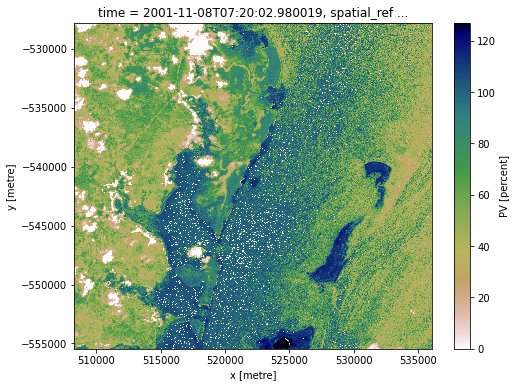

In [12]:
# Visualise the loaded tile
fc1.PV.plot.imshow(cmap="gist_earth_r", figsize=(8, 6))
plt.show()

### Mask water from FC with WOfS

Using the mask created above we can mask water from the FC image, leaving areas classified as land.

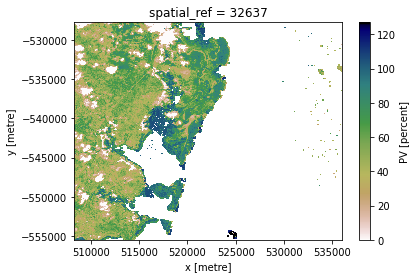

In [13]:
masked = fc1.where(wetwofl.water == False)
masked.PV.plot(cmap="gist_earth_r")
plt.show()

### Create custom masks by combining flags

Flags can be combined. 
When chaining flags together, they will be combined in a logical AND fashion. 
This process works by passing a dictionary with true/false values to the make_mask function. 
This allows you to chose whether you want to remove clouds and/or cloud shadows from imagery.

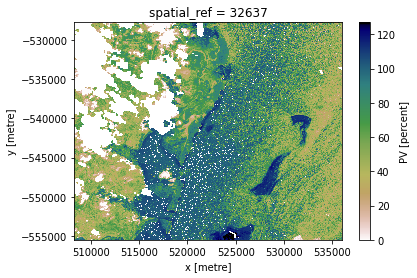

In [14]:
# Removing clouds and their shadows
clear = {"cloud_shadow": False, "cloud": False}

cloudfree = masking.make_mask(wofl, **clear)
cloudfree_fc = fc1.where(cloudfree.water == True)
cloudfree_fc.PV.plot(cmap="gist_earth_r")
plt.show()

Or, to look at only the clear areas which are good quality data and not wet, we can use the 'dry' flag.


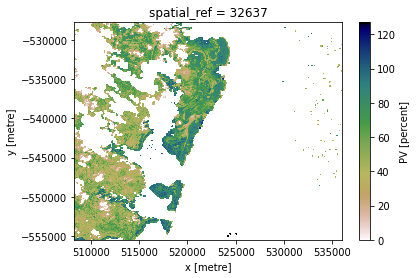

In [15]:
# FC where it's clear and dry
good_data_mask = masking.make_mask(wofl, dry=True)
good_fc = fc1.where(good_data_mask.water == True)
good_fc.PV.plot(cmap="gist_earth_r")
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](../../../genindex.rst)